In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import pytz
cst = pytz.timezone('Asia/Shanghai')
utc = pytz.utc

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 120

# 1. data

## 1.1.  Ad features
1. adgroup_id：**Ad ID**(int) ;
2. cate_id：category ID;
3. campaign_id：campaign ID;
4. brand：brand ID;
5. customer_id: Advertiser ID;
6. price: the price of item


In [3]:
feature_df = pd.read_csv('data/ad_feature.csv')

In [4]:
feature_df.head(2)

,adgroup_id,cate_id,campaign_id,customer,brand,price
0,63133,6406,83237,1,95471.0,170.0
1,313401,6406,83237,1,87331.0,199.0


In [5]:
print( 'Ads: %d' % len(feature_df))
print( 'Categories: %d' % feature_df['cate_id'].nunique())
print( 'campaigns: %d' % feature_df['campaign_id'].nunique())
print( 'Advertisers : %d' % feature_df['customer'].nunique())
print( 'Brands : %d' % feature_df['brand'].nunique())

Ads: 846811
Categories: 6769
campaigns: 423436
Advertisers : 255875
Brands : 99814


## 1.2. User data

### 1.2.1 User features
1. userid: user ID;
2. cms_segid: Micro group ID;
3. cms_group_id: cms_group_id;
4. final_gender_code: gender 1 for male , 2 for female
5. age_level: age_level
6. pvalue_level: Consumption grade, 1: low,  2: mid,  3: high
7. shopping_level: Shopping depth, 1: shallow user, 2: moderate user, 3: depth user
8. occupation: Is the college student 1: yes, 0: no?
9. new_user_class_level: City level

In [6]:
user_df = pd.read_csv('data/user_profile.csv')

In [7]:
user_df.head(2)

,userid,cms_segid,cms_group_id,final_gender_code,age_level,pvalue_level,shopping_level,occupation,new_user_class_level
0,234,0,5,2,5,NaN,3,0,3.0
1,523,5,2,2,2,1.0,3,1,2.0


### 1.2.2 User behavior

#### (Can be engineered into features)

* ipv: browse
* cart: add to the shopping cart
* fav:favor
* buy:buy


In [17]:
behave_df = pd.read_csv('data/behavior_log_5m.csv')

#### Convert time zone

(Bigint, 1494032110 stands for 2017-05-06 08:55:10); validated by the line below

In [9]:
#utc.localize(datetime.utcfromtimestamp(1494032110)).astimezone(cst)

datetime.datetime(2017, 5, 6, 8, 55, 10, tzinfo=<DstTzInfo 'Asia/Shanghai' CST+8:00:00 STD>)

In [18]:
behave_df['time_CST'] = behave_df['time_stamp']\
                        .apply(lambda x: utc.localize(datetime.utcfromtimestamp(x)).astimezone(cst))
                        #.apply(lambda x: utc.localize(datetime.utcfromtimestamp(x)).astimezone(cst))

OSError: [Errno 22] Invalid argument

In [11]:
behave_df.head(2)

,user,time_stamp,btag,cate,brand
0,558157,1493741625,pv,6250,91286
1,558157,1493741626,pv,6250,91286


In [12]:
print( 'Users: %d' % len(user_df))
print( 'Number of Behavior Data: %d' % len(behave_df))

Users: 1061768
Number of Behavior Data: 4999999


## 1.3 raw click-not click data ("label")
1. user: User ID(int);
2. time_stamp: time stamp(Bigint, 1494032110 stands for 2017-05-06 08:55:10);
3. adgroup_id: adgroup ID(int);
4. pid: scenario;
5. noclk: 1 for not click, 0 for click;
6. clk: 1 for click, 0 for not click;


In [13]:
raw_df = pd.read_csv('data/raw_sample_2m.csv')

In [14]:
raw_df['time_CST'] = raw_df['time_stamp']\
                        .apply(lambda x: utc.localize(datetime.utcfromtimestamp(x)).astimezone(cst))

In [15]:
raw_df.sort_values('time_stamp').head(2)

,user,time_stamp,adgroup_id,pid,nonclk,clk,time_CST
101522,874257,1494000000,27032,430548_1007,1,0,2017-05-06 00:00:00+08:00
237305,874257,1494000000,54756,430548_1007,1,0,2017-05-06 00:00:00+08:00


In [16]:
print( 'Total number of Data: %d' % len(raw_df))

Total number of Data: 1999999


# 2. Before ML: Data overview

## 2.2 Overall click ratio 

In [19]:
ratio = sum(raw_df['clk'])/len(raw_df)
print('Only bout {:.2f}% results are "click"'.format(ratio*100))

Only bout 4.96% results are "click"


The result/labels are very unbalences: that means accuracy is not a good measure of model performance.

We should keep track of **precision & recall** instead.

## 2.3 Validate some intuition

brainstorm: 
* Target demography differ among categories (gender, age)
* Price/brand related to income (and related to city level, occupation,...); but category specific
* Users acted on similar item (category, brand) more likely to click

In [20]:
raw_df.tail(2) 
# feature_df[feature_df['brand'] == 32233].tail() 
# look at demographic profile on ad #197055

,user,time_stamp,adgroup_id,pid,nonclk,clk,time_CST
1999997,234920,1494323637,326271,430548_1007,1,0,2017-05-09 17:53:57+08:00
1999998,68014,1494674768,326271,430548_1007,1,0,2017-05-13 19:26:08+08:00


In [21]:
feature_df.columns


Index(['adgroup_id', 'cate_id', 'campaign_id', 'customer', 'brand', 'price'], dtype='object')

In [22]:
user_df.columns

Index(['userid', 'cms_segid', 'cms_group_id', 'final_gender_code', 'age_level',
       'pvalue_level', 'shopping_level', 'occupation',
       'new_user_class_level '],
      dtype='object')

In [23]:
user_df_oh = pd.get_dummies(user_df[['userid','final_gender_code','age_level','shopping_level', 'occupation','new_user_class_level ']]\
                            , columns =['final_gender_code','age_level','shopping_level', 'occupation','new_user_class_level ']
                            , prefix=['gender','age','shopping', 'student','city'])

In [24]:
raw_joined = raw_df.join(user_df_oh.set_index('userid'), on='user')\
                   .join(feature_df[['adgroup_id', 'cate_id', 'brand', 'price']].set_index('adgroup_id'), on='adgroup_id')

In [25]:
f =  {'user':['count'], 'gender_1':['sum'], 'age_1':['sum'], 'age_2':['sum'], 'age_3':['sum'], 'age_4':['sum'],\
       'age_5':['sum'], 'age_6':['sum'], 'shopping_2':['sum'], 'shopping_3':['sum'] ,'student_1':['sum'],\
      'city_2.0':['sum'], 'city_3.0':['sum'], 'city_4.0':['sum']}
    
# devices_report = trips_report.groupby('device_id').agg(f)

In [26]:
raw_by_brand_all = raw_joined.groupby(['brand']).agg(f)
raw_by_brand = raw_joined.groupby(['brand', 'clk']).agg(f)
raw_by_brand.columns = raw_by_brand.columns.get_level_values(0)
raw_by_brand_all.columns = raw_by_brand.columns.get_level_values(0)

In [27]:
raw_by_brand_all[raw_by_brand_all['user']> 5000].head()['user']

brand
220468.0     6356
353787.0    22577
425589.0     5801
Name: user, dtype: int64

In [28]:
raw_by_brand.reset_index(inplace =True)

In [29]:
temp = raw_by_brand[raw_by_brand['brand'] == 220468].copy()

In [30]:
temp.columns

Index(['brand', 'clk', 'user', 'gender_1', 'age_1', 'age_2', 'age_3', 'age_4',
       'age_5', 'age_6', 'shopping_2', 'shopping_3', 'student_1', 'city_2.0',
       'city_3.0', 'city_4.0'],
      dtype='object')

In [31]:
cols = ['city_2.0', 'city_3.0', 'age_3','age_4', 'gender_1', 'student_1', 'age_5', 'age_1', 'age_2', 'city_4.0',
       'age_6', 'shopping_3', 'shopping_2']

In [32]:
for col in cols:
    temp[col +'_ratio'] = temp[col]/ temp['user']

In [33]:
temp.columns

Index(['brand', 'clk', 'user', 'gender_1', 'age_1', 'age_2', 'age_3', 'age_4',
       'age_5', 'age_6', 'shopping_2', 'shopping_3', 'student_1', 'city_2.0',
       'city_3.0', 'city_4.0', 'city_2.0_ratio', 'city_3.0_ratio',
       'age_3_ratio', 'age_4_ratio', 'gender_1_ratio', 'student_1_ratio',
       'age_5_ratio', 'age_1_ratio', 'age_2_ratio', 'city_4.0_ratio',
       'age_6_ratio', 'shopping_3_ratio', 'shopping_2_ratio'],
      dtype='object')

In [34]:
temp[['shopping_2_ratio', 'shopping_3_ratio']]

,shopping_2_ratio,shopping_3_ratio
22188,0.048955,0.899104
22189,0.060606,0.900000


In [35]:
temp[['shopping_2_ratio', 'shopping_3_ratio']].values

array([[0.04895453, 0.89910388],
       [0.06060606, 0.9       ]])

In [36]:
Y = [i[0] for i in temp[['gender_1_ratio']].values]

NameError: name 'ind' is not defined

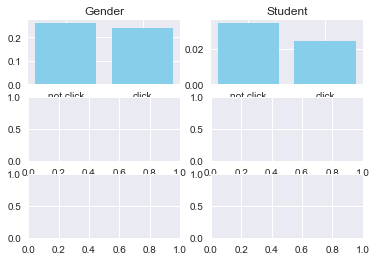

In [39]:
fig, axes = plt.subplots(ncols=2, nrows=3)

ax = axes[0][0]
Y = [i[0] for i in temp[['gender_1_ratio']].values]
rects1 = ax.bar(['not click','click'], Y,  color='SkyBlue')
ax.set_title('Gender')

ax = axes[0][1]
Y = [i[0] for i in temp[['student_1_ratio']].values]
rects1 = ax.bar(['not click','click'], Y,  color='SkyBlue')
ax.set_title('Student')


rects1 = ax.bar(ind - width/2, men_means, width, yerr=men_std,
                color='SkyBlue', label='Men')
rects2 = ax.bar(ind + width/2, women_means, width, yerr=women_std,
                color='IndianRed', label='Women')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

## How to do train-test split?


In [106]:
raw_df['datetime_cst'] =  raw_df['time_stamp'].apply(lambda x: utc.localize(datetime.utcfromtimestamp(x)).astimezone(cst))

In [108]:
train =raw_df[raw_df['datetime_cst'] < utc.localize(datetime(2017, 5,11)).astimezone(cst)]
test = raw_df[raw_df['datetime_cst'] >= utc.localize(datetime(2017, 5,11)).astimezone(cst)]

In [109]:
len(train)/len(raw_df)

0.648022824011412

## Model 1: demography + ad feature


In [92]:
train.columns

Index(['user', 'time_stamp', 'adgroup_id', 'pid', 'nonclk', 'clk',
       'datetime_cst'],
      dtype='object')

In [93]:
feature_df.columns

Index(['adgroup_id', 'cate_id', 'campaign_id', 'customer', 'brand', 'price'], dtype='object')

In [113]:
def grab_features_1(subset):
    XY = subset[['user', 'adgroup_id', 'clk']]\
        .join(feature_df[['adgroup_id', 'cate_id', 'price']].set_index('adgroup_id'), on='adgroup_id')
    XY = XY.join(user_df[['userid', 'final_gender_code', 'age_level','occupation']].set_index('userid'), on='user')
    XY.drop(['user','adgroup_id'], axis=1, inplace=True)
    return XY

In [114]:
train_df= grab_features_1(train)
test_df= grab_features_1(test)

In [117]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [131]:
test_df[['cate_id', 'price', 'final_gender_code', 'age_level', 'occupation']].head(2)

,cate_id,price,final_gender_code,age_level,occupation
2,7958,85.0,2.0,5.0,0.0
3,7958,60.0,2.0,5.0,0.0


In [98]:
%%time


CPU times: user 38.5 ms, sys: 15.9 ms, total: 54.4 ms
Wall time: 54.4 ms


In [134]:
%%time
X =[]
for r in train_df[['cate_id', 'price', 'final_gender_code', 'age_level', 'occupation']].itertuples():
    X.append(list(r)[1:])
Y = list(train_df['clk'])

CPU times: user 3.92 s, sys: 387 ms, total: 4.31 s
Wall time: 4.36 s


In [135]:
len(X)

1221309

In [103]:
len(Y)

1296045

In [112]:
len(train_X_df)

1296045

In [64]:
# X=[]

# for row in temp.iterrows():
#     index, data = row
#     X.append(data.tolist())

In [128]:
temp = X[:5]

In [129]:
temp

[[9025, 17.0, 1.0, 2.0, 0.0],
 [1626, 63.0, 2.0, 5.0, 0.0],
 [5239, 176.0, 2.0, 4.0, 0.0],
 [5239, 176.0, 2.0, 6.0, 0.0],
 [5239, 176.0, 2.0, 4.0, 0.0]]

In [120]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn import svm, base

In [125]:


X[:10]

[[9025, 17.0, 1.0, 2.0, 0.0],
 [1626, 63.0, 2.0, 5.0, 0.0],
 [5239, 176.0, 2.0, 4.0, 0.0],
 [5239, 176.0, 2.0, 6.0, 0.0],
 [5239, 176.0, 2.0, 4.0, 0.0],
 [5239, 176.0, 1.0, 5.0, 0.0],
 [5239, 176.0, 2.0, 4.0, 0.0],
 [7211, 289.0, 2.0, 3.0, 0.0],
 [7211, 289.0, 2.0, 3.0, 0.0],
 [7211, 289.0, 2.0, 3.0, 0.0]]

In [85]:
StandardScaler(with_mean=False).fit_transform(enc.fit_transform(temp)).toarray()

array([[0.        , 0.        , 2.5       , 2.5       , 0.        ,
        1.        , 0.24928294, 1.50755672],
       [2.5       , 0.        , 0.        , 0.        , 2.5       ,
        1.        , 0.92381325, 3.76889181],
       [0.        , 2.04124145, 0.        , 0.        , 2.5       ,
        1.        , 2.58081163, 3.01511345],
       [0.        , 2.04124145, 0.        , 0.        , 2.5       ,
        1.        , 2.58081163, 4.52267017],
       [0.        , 2.04124145, 0.        , 0.        , 2.5       ,
        1.        , 2.58081163, 3.01511345]])

In [136]:
enc = OneHotEncoder(categorical_features=[True,False,True,False, True])
X1  = enc.fit_transform(X)
X2 = StandardScaler(with_mean=False).fit_transform(X1) 

In [ ]:
RandomForestRegressor.fit(X2, Y)

In [ ]:
svm.LinearSVC().fit(X2, Y)

In [ ]:
pipe = Pipeline([
  ('standard',StandardScaler()), 
    ('select', ColumnSelector([0,1,2,3,5,9,10,11,12,15,16,17,19,20])),# 0,1,2,3,5,9,10,11,12,15,16,17,19,20
#   ('PCA', PCA(n_components = 13) ), 
   ("est", svm.LinearSVC() )#
#     ("est", RandomForestClassifier(max_depth=4))
])

In [42]:
enc.transform([[1626.0, 171.0, 2.0, 4.0, 0.0]]).toarray()

array([[  1.,   0.,   0.,   0.,   1.,   1., 171.,   4.]])